# Sentiment Analysis on Mobile Phone User Reviews
***Author: Reynaldo Vazquez***  
***November 17, 2017***

**[GitHub Pages](https://reyvaz.github.io/Sentiment-Analysis-Mobile/)**

## Tests different algorithms for sentiment classification of user reviews


Different specifications of Naïve-Bayes and Logistic-Regression with varying parameters and model complexity are tested in order to classify user reviews as positive or negative. 

The dataset used contains over 400 thousand reviews of mobile phones sold on Amazon extracted by [PromptCloud](https://www.promptcloud.com/). It was downloaded from [Kaggle](https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones) on November 16, 2017. From this dataset, only the columns `Rating` and `Review` were used for the analysis. 

Original ratings consist of a scale from 1 to 5, with 5 as the most favorable rating. Ratings of 4 and 5 were assumed to be positive, 1 and 2 negative, and 3 neutral. Reviews deemed neutral were discarded. With this scheme, ~3/4 of the reviews in the original dataset were labeled as positive and ~1/4 as negative. 

If corrective measures (learning from deficiencies) are the main purpose of this classification, given the setup of the model, precision would make for a better metric of focus. i.e. make sure that reviews classified as positive are actually positive. However, more generally, the nature of this problem does not allocate more importance to misclassification of negative reviews as positive or vice-versa. Additionally, even though the dataset is somewhat unbalanced, both classes are well (relatively) represented. With this in mind, main emphasis is placed on maximizing the area under the ROC curve and accuracy. Nevertheless, precision and recall are also individually considered.

The best performing algorithm is a Logistic Regression with regularization parameter C = 10 on words and bigrams with document frequencies of at least 2 in the training dataset. Its performance metrics are as follow,

```
                                      Param  Accuracy    Recall  Precision   ROC AUC
LogisticRegression (ngrams)          C = 10  0.979352  0.988174   0.984161  0.970901
```

### Importing the dataset

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('amazon-reviews-unlocked-mobile-phones.zip', usecols = [3, 4])
pd.set_option('display.max_colwidth', 90)
pd.set_option('display.width', 110)
print('\nImported data shape: ', df.shape)
print('Column names:', list(df.columns))
df.head()
print('Rating levels:', sorted(df['Rating'].unique()))


Imported data shape:  (413840, 2)
Column names: ['Rating', 'Reviews']
Rating levels: [1, 2, 3, 4, 5]


### Drop missing values

In [2]:
nans = df.isnull().any(axis = 1)
print(nans.sum(), 'rows contain NaN')
df.dropna(inplace=True)
print('Shape after dropping NaNs:', list(df.shape))

62 rows contain NaN
Shape after dropping NaNs: [413778, 2]


### Remove ratings equal to 3
Ratings equal to 3 are deemed neutral

In [3]:
print('Total neutral raitings:', sum(df['Rating'] == 3))
df = df[df['Rating'] != 3]
print('Shape after elimintating neutral ratings:', list(df.shape))

Total neutral raitings: 31763
Shape after elimintating neutral ratings: [382015, 2]


### Encode ratings as positive or negative
Ratings of 4 and 5 are considered positve. Ratings of 1 and 2 are considered negative

In [4]:
df = df.assign(Positive = np.where(df['Rating'] > 3, 1, 0))
print('Fraction of positive ratings:', df['Positive'].mean())
df.head()

Fraction of positive ratings: 0.7459235893878513


,Rating,Reviews,Positive
0,5,"I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on...",1
1,4,"nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. ne...",1
2,5,Very pleased,1
3,4,It works good but it goes slow sometimes but its a very good phone I love it,1
4,4,Great phone to replace my lost phone. The only thing is the volume up button does not ...,1


### Split dataset into training and testing

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], 
                                                    df['Positive'], 
                                                    random_state=0)

### Set up function that will calculate performance metrics and populate comparison matrix

In [6]:
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score, 
                             precision_score)

def get_metrics(X_to_test, model, notes, y_test = y_test):
  '''
  Calculates model performance metrics and populates model comparison matrix
  '''
  model.fit(X_train_transformed, y_train)
  predictions = model.predict(X_to_test)
  auc  = roc_auc_score(y_test, predictions)
  acc  = accuracy_score(y_test, predictions)
  rec  = recall_score(y_test, predictions)
  prec = precision_score(y_test, predictions)
  model_name = str(model)[0:str(model).index('(')] + features_model
  metrics.loc[len(metrics)] = [model_name, notes, acc, rec, prec, auc]

### Set up classification specifications to be tested
Naive-Bayes and Linear Regression with varying parameters

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

def  test_models():
  for param in [0.01, 0.1]:
    notes = 'alpha = ' + str(param)
    get_metrics(X_test_transformed, MultinomialNB(alpha=param), notes)
  for param in [1, 10]:
    notes = 'C = ' + str(param)
    get_metrics(X_test_transformed, LogisticRegression(C = param), notes)

### Set up performance comparison Matrix

In [8]:
colnames = ['Model', 'Param', 'Accuracy', 'Recall', 'Precision', 'ROC AUC']
metrics =  pd.DataFrame(columns = colnames)  

### Feature Specification 1:  Features built using CountVectorizer with default settings
#### i.e. features are all the words in the training set, and no extra features

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
features_model = ' (words)'
vect = CountVectorizer().fit(X_train)
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

test_models()
metrics.set_index('Model')

,Param,Accuracy,Recall,Precision,ROC AUC
Model,,,,,
MultinomialNB (words),alpha = 0.01,0.928516,0.957856,0.946766,0.900412
MultinomialNB (words),alpha = 0.1,0.927783,0.956717,0.946851,0.900068
LogisticRegression (words),C = 1,0.949489,0.974984,0.957930,0.925069
LogisticRegression (words),C = 10,0.952463,0.975265,0.961448,0.930621


By all metrics, the best performing algorithm with **Feature Specification 1** is the Logistic Regression with C = 10 (henceforth **baseline**).

### Feature Specification 2:  words and bigrams as features
Ignoring terms that have a document frequency strictly lower than 2

In [10]:
features_model = ' (ngrams)'
vect = CountVectorizer(min_df=2, ngram_range=(1,2)).fit(X_train)
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

metrics =  pd.DataFrame(columns = colnames)
test_models()
metrics.set_index('Model')

,Param,Accuracy,Recall,Precision,ROC AUC
Model,,,,,
MultinomialNB (ngrams),alpha = 0.01,0.963478,0.976235,0.974755,0.951258
MultinomialNB (ngrams),alpha = 0.1,0.962138,0.972846,0.976223,0.951880
LogisticRegression (ngrams),C = 1,0.977760,0.987836,0.982394,0.968108
LogisticRegression (ngrams),C = 10,0.979352,0.988174,0.984161,0.970901


All models with **Feature Specification 2** perform better than baseline. By all metrics, both Logistic Regression algorithms are superior to their Naive-Bayes counterparts. Logistic Regression with C = 10 seems to perform slightly better than the rest. 

### Eplore New Features

#### Find indexes of positive and negative ratings in training set for additional feature search

In [11]:
negs  = y_train == 0
negs  = [i for i, x in enumerate(negs) if x]
pves = y_train == 1
pves = [i for i, x in enumerate(pves) if x]

### Compare Lenghts (Number of Characters) between Positive and Negative Reviews

In [12]:
doc_lengths = np.array([len(d) for d in X_train])
mean_len_negs = np.mean(doc_lengths[negs])
mean_len_pves = np.mean(doc_lengths[pves])
print('Average Length', '\nNegatives: ', mean_len_negs, 'chars',
      '\nPositives: ', mean_len_pves, 'chars')

Average Length 
Negatives:  263.178172861 chars 
Positives:  191.391353348 chars


#### On average, negative reviews are longer

### Compare Digit Counts between Positive and Negative Reviews

In [13]:
digits = X_train.str.findall('\d')
dig_counts = np.array([len(d) for d in digits])
mean_dig_negs = np.mean(dig_counts[negs])
mean_dig_pves = np.mean(dig_counts[pves])
print('Average digit counts', '\nNegatives: ', mean_dig_negs, 'digits',
      '\nPositives: ', mean_dig_pves, 'digits')

Average digit counts 
Negatives:  1.50647438456 digits 
Positives:  1.17457912458 digits


#### On average, negative reviews contain more digits

### Compare Non-Alphanumeric Characters between Positive and Negative Reviews

In [14]:
non_alnum = X_train.str.findall('\W')
non_alnum_counts = np.array([len(d) for d in non_alnum])
mean_nw_negs = np.mean(non_alnum_counts[negs])
mean_nw_pves = np.mean(non_alnum_counts[pves])
print('Average non-alnum char counts', '\nNegatives: ', mean_nw_negs, 
      'non-alnum chars', '\nPositives: ', mean_nw_pves, 'non-alnum chars')

Average non-alnum char counts 
Negatives:  56.2406462 non-alnum chars 
Positives:  40.677506547 non-alnum chars


#### On average, negative reviews contain more non-alphanumeric characters

### Functions to transform original X_sets into sparse matrices with additional features

In [15]:
from scipy.sparse import csr_matrix, hstack
def add_features(X_sparse, new_features):
    """
    Returns sparse feature matrix with new feature added.
    new_features can be a feature or a list of features.
    """
    return hstack([X_sparse, csr_matrix(new_features).T], 'csr')

def transform_X(X, new_features):
  X_vectorized  = vect.transform(X)
  X_transformed = add_features(X_vectorized, new_features)
  return X_transformed

from sklearn.preprocessing import MinMaxScaler
def vector_scaler(x):
  return MinMaxScaler().fit_transform(x.reshape(-1, 1))[:,0]

### Feature Specification 3: 
Same as **Feature Specification 2** with review length feature added
#### Calculate the New Feature (Review Length) for the Test Set
Of the three extra features explored, length seems to be the one that could improve prediction performanced. The differences in the other variables do not seem large enough.

In [16]:
doc_lengths_test = np.array([len(d) for d in X_test])
import warnings
warnings.filterwarnings('ignore')
doc_lengths = vector_scaler(doc_lengths)
doc_lengths_test = vector_scaler(doc_lengths_test)

In [17]:
features_model = ' (ngrams +)'
vect = CountVectorizer(min_df=2, ngram_range=(1,2)).fit(X_train)

X_train_transformed = transform_X(X_train, doc_lengths)
X_test_transformed = transform_X(X_test, doc_lengths_test)

metrics =  metrics[2:4]
for param in [1, 10]:
    notes = 'C = ' + str(param)
    get_metrics(X_test_transformed, LogisticRegression(C = param), notes)
metrics.set_index('Model')

,Param,Accuracy,Recall,Precision,ROC AUC
Model,,,,,
LogisticRegression (ngrams +),C = 10,0.979373,0.988061,0.984297,0.971050
LogisticRegression (ngrams),C = 10,0.979352,0.988174,0.984161,0.970901


Adding the new feature in **Feature Specification 3** shows only a modest improvement on the Linear Regression.

### Define function to extract important features

In [18]:
def sm_lg(measure, num = 10):
  '''
  Retrieves the features with the smallest and largest specified measure.
  measure could be i.e. model coefficients or tfidf index.
  num specifies the number of features to be returned
  '''
  sorted_index   = measure.argsort()
  sm_index = sorted_index[:num]
  lg_index  = sorted_index[:-(num+1):-1]
  sm_series = pd.Series(measure[sm_index], index = feature_names[sm_index])
  sm_series = sm_series.iloc[np.lexsort([sm_series.index, sm_series.values])]
  lg_series  = pd.Series(measure[lg_index], index = feature_names[lg_index])
  lg_series  = lg_series.iloc[np.lexsort([lg_series.index, -lg_series.values])]
  return sm_series, lg_series

### Feature Analysis
Although Logistic Regression Model with Feature Specification 3 and C = 10 performs slightly better than its counterpart with Feature Specification 2, the latter is chosen for its simplicity.

In [19]:
vect = CountVectorizer(min_df=2, ngram_range=(1,2)).fit(X_train)
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

feature_names = np.array(vect.get_feature_names())

model = LogisticRegression(C = 10)
model.fit(X_train_transformed, y_train)

important_features = sm_lg(model.coef_[0], 12)
most_neg = important_features[0]
most_pve = important_features[1]

### Plot Most Important Features

<IPython.core.display.Javascript object>


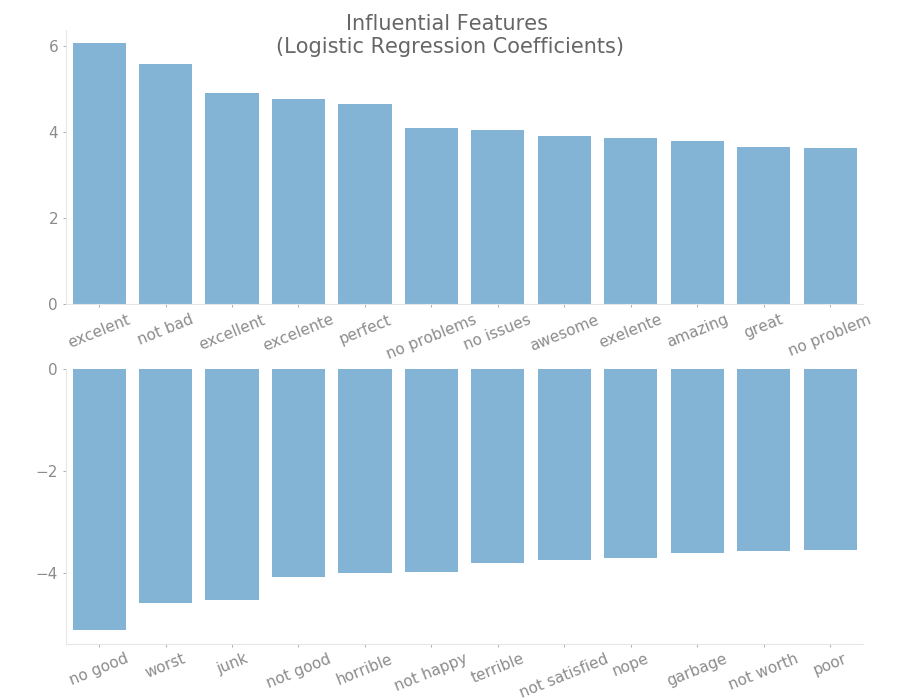

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt

sentiments = [most_pve, most_neg]

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.tight_layout()
axs = [ax1,ax2]
fig.set_size_inches(9, 7)
fig.suptitle('Influential Features \n(Logistic Regression Coefficients)', 
             fontsize=15, color = '0.4')
ax1.set_yticks(range(0, 7, 2))
ax2.set_yticks(range(-6, 1, 2))

for n in range(0,len(axs)):
  sentiment = sentiments[n]
  w = np.arange(len(sentiment))
  axs[n].bar(w, sentiment.values, align='center', alpha=0.55)
  axs[n].tick_params(length=2, width=0.5, colors='0.55', labelsize = 11)
  axs[n].set_xticks(np.arange(len(sentiment)))
  axs[n].set_xticklabels(sentiment.index, rotation=22)
  xmin = min(w) - 0.5
  xmax = max(w) + 0.5
  axs[n].set_xlim(xmin, xmax)
  for spine in axs[n].spines.values():
        spine.set_edgecolor('#e6e6e6')
  axs[n].spines['top'].set_visible(False)
  axs[n].spines['right'].set_visible(False)

### Conclusion
Best performing algorithms were two Logistic Regression Models that include words and bigrams as features amd regularization parameter C = 10. One of these two included the length of the review as an additional feature. However, the preformance inprovement of the additional feature was almost negligible so is was discarded for further analysis. 